# Analysis based on Florida Department of Health Data
    David West
    Lead Data Scientist
    IBM

   Westd@us.ibm.com

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from datetime import datetime
from datetime import date
from datetime import timedelta
now = (str(datetime.now()))
nowdate = now[0:10] 
print(nowdate)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 65em; }</style>"))


import matplotlib.ticker
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=14):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator        


2020-06-11


# FLORIDA DEPT OF HEALTH DATA

In [86]:
# FLORIDA DEPT OF HEALTH Data from arcgis
src5= "https://opendata.arcgis.com/datasets/37abda537d17458bae6677b8ab75fcb9_0.csv"
ds5=pd.read_csv(src5, error_bad_lines=False,parse_dates=["Case1","EventDate","ChartDate"])
ds5.head()

,County,Age,Age_group,Gender,Jurisdiction,Travel_related,Origin,EDvisit,Hospitalized,Died,Case_,Contact,Case1,EventDate,ChartDate,ObjectId
0,Manatee,43.0,35-44 years,Male,FL resident,No,NaN,NO,NO,NaN,Yes,NO,2020-06-03 05:00:00+00:00,2020-06-02 00:00:00+00:00,2020-06-03 05:00:00+00:00,1
1,Pinellas,16.0,15-24 years,Female,FL resident,No,NaN,NO,NO,NaN,Yes,Yes,2020-06-03 05:00:00+00:00,2020-05-31 00:00:00+00:00,2020-06-03 05:00:00+00:00,2
2,Duval,39.0,35-44 years,Female,FL resident,Unknown,NaN,NaN,NaN,NaN,Yes,NaN,2020-06-03 05:00:00+00:00,2020-04-28 00:00:00+00:00,2020-06-03 05:00:00+00:00,3
3,Dade,64.0,55-64 years,Female,FL resident,No,NaN,UNKNOWN,UNKNOWN,NaN,Yes,UNKNOWN,2020-06-03 05:00:00+00:00,2020-06-03 00:00:00+00:00,2020-06-03 05:00:00+00:00,4
4,Dade,57.0,55-64 years,Female,FL resident,No,NaN,UNKNOWN,UNKNOWN,NaN,Yes,UNKNOWN,2020-06-03 05:00:00+00:00,2020-06-03 00:00:00+00:00,2020-06-03 05:00:00+00:00,5


In [87]:
# I wanted to get a look at the characteristics of the recent deaths.
FLDeaths = ds5[ds5['Died']=="Yes"]
#FLDeaths.tail(50)
RecentD = FLDeaths[FLDeaths['Case1']>='2020-06-01'].reset_index()


In [88]:
# Just made a list of columns to copy into the code
ds5.columns.to_list()

['County',
 'Age',
 'Age_group',
 'Gender',
 'Jurisdiction',
 'Travel_related',
 'Origin',
 'EDvisit',
 'Hospitalized',
 'Died',
 'Case_',
 'Contact',
 'Case1',
 'EventDate',
 'ChartDate',
 'ObjectId']

In [90]:
#Get a count of the deaths by age for plotting purposes
deaths = ds5[ds5['Died']=="Yes"].drop([
 

 'Age_group',
 'Gender',
 'Jurisdiction',
 'Travel_related',
 'Origin',
 'EDvisit',
 'Hospitalized',
 'Case_',
 'Contact',
 'EventDate',
 'ChartDate'],axis=1)
dthplt=deaths.groupby(['Age']).count().reset_index()
cnt2 = dthplt.sum()
cnt2
dthplt.tail()



,Age,County,Died,Case1,ObjectId
74,100.0,9,9,9,9
75,101.0,11,11,11,11
76,102.0,6,6,6,6
77,103.0,4,4,4,4
78,104.0,1,1,1,1


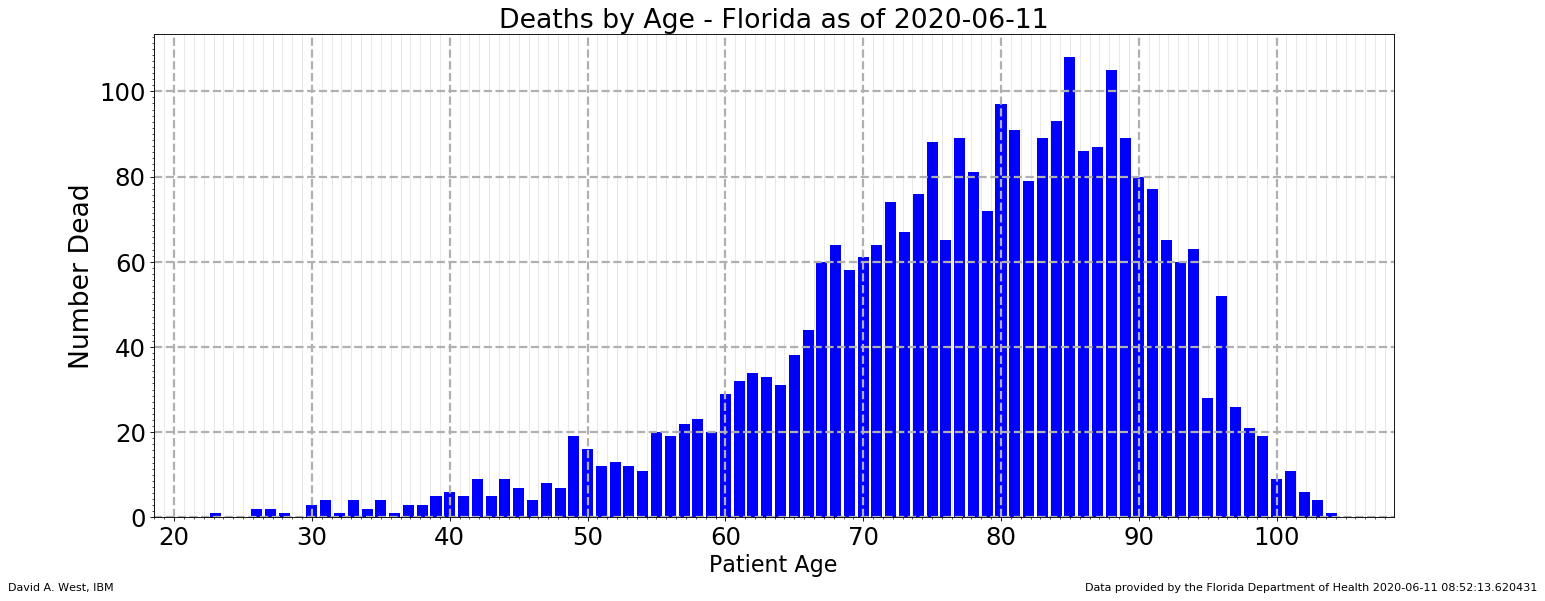

In [92]:
fig=plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')#.legend( prop={'size': 18})
plt.bar( 'Age','Died', data=dthplt, color='blue',linewidth=2)


title = "Deaths by Age - Florida as of " + nowdate
matplotlib.ticker.AutoMinorLocator(n=2)
plt.minorticks_on()
plt.grid( b=True,which='minor', axis='x', color='black', linestyle='-',alpha=0.1)
plt.title(title, fontsize=24)
plt.xlabel('Patient Age', fontsize=20)
plt.ylabel('Number Dead', fontsize=24)
plt.rcParams['xtick.labelsize'] =22
plt.figtext(0.99, 0.01, 'Data provided by the Florida Department of Health ' + now, horizontalalignment='right')
plt.figtext(0.10, 0.01, 'David A. West, IBM', horizontalalignment='right')
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.grid(which='major', axis='both', linestyle='--',linewidth='2')


# Examine data quality over time.
# What is the proportion of cases where the patient's hospitalization status is unknown?
 A recent article by The Capitolist suggests that hospitalization rates are diminishing in Florida.  https://thecapitolist.com/florida-case-numbers-suggests-covid-19-may-be-losing-potency/?fbclid=IwAR2esb48EjRhrZx6gEiWlg90fv2Cg_olouvMI9vawYtvYKviSqHyXvdHuDE
  I dispute this conclusion.  I've noticed there are many cases where the hospitalization status is "UNKNOWN".  If the proportion of unknowns remains constant over time, then the data MAY support
 The Capitolist's conclusion.  But if it is not consistent over time, the hospitalization rate's change over time cannot be determined from the data and his conclusion is faulty.
  Time to check.

In [103]:
# Let's see what the field holds...we are expecting YES, NO and UNKNOWN
ds5["Hospitalized"].unique()

array(['NO', nan, 'UNKNOWN', 'YES'], dtype=object)

In [105]:
ds5["Hospitalized"].value_counts(dropna = False)

NO         43028
UNKNOWN    12272
YES        11621
NaN          450
Name: Hospitalized, dtype: int64

### Looks like there are some NaNs in the field...gotta address those first.  There aren't many.

In [102]:
ds5["Hospitalized"].replace(np.nan, 'UNKNOWN', regex=True).value_counts(dropna = False)

NO         43028
UNKNOWN    12722
YES        11621
Name: Hospitalized, dtype: int64

# Discussion:

  The number of UNKNOWNS is greater than the number of known YES values.  This leaves the possibility that the overall hospitalization rate is more than twice what we believe.

### Now for the quick and dirty way to count the distributions of values over time.
 There are many different ways to do this.  This is the simplest in my opinion.  There may be better ways.

In [121]:
unk = ds5[ds5['Hospitalized']=="UNKNOWN"]
unk['hunk'] = 1
yes = ds5[ds5['Hospitalized']=="YES"]
yes['hyes'] = 1
nos = ds5[ds5['Hospitalized']=="NO"]
nos['hnos'] = 1
ds6 = unk.append(yes)
ds6 = ds6.append(nos).fillna(0)
hosp=ds6[ds6['Case1']>='2020-03-15'].groupby(["Case1"]).sum().reset_index()
hosp['pctunk'] = 100 * hosp['hunk'] / (hosp['hunk'] + hosp['hyes'] + hosp['hnos'])
# Ratio of UNKNOWN to YES
hosp['doubt'] =  hosp['hunk'] / hosp['hyes']
hosp['possible'] = 100 * (hosp['hunk'] +hosp['hyes'])/ (hosp['hunk'] + hosp['hyes'] + hosp['hnos'])
hosp.head()

<ipython-input-121-817b9446c5c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unk['hunk'] = 1
<ipython-input-121-817b9446c5c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yes['hyes'] = 1
<ipython-input-121-817b9446c5c2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,Case1,Age,ObjectId,hunk,hyes,hnos,pctunk,doubt,possible
0,2020-03-15 05:00:00+00:00,1626.0,11177,0.0,10.0,23.0,0.000000,0.000000,30.303030
1,2020-03-16 05:00:00+00:00,1855.0,16406,0.0,15.0,16.0,0.000000,0.000000,48.387097
2,2020-03-17 05:00:00+00:00,3466.0,46417,7.0,16.0,47.0,10.000000,0.437500,32.857143
3,2020-03-18 05:00:00+00:00,5160.0,80524,4.0,35.0,68.0,3.738318,0.114286,36.448598
4,2020-03-19 05:00:00+00:00,4510.0,80384,7.0,20.0,60.0,8.045977,0.350000,31.034483


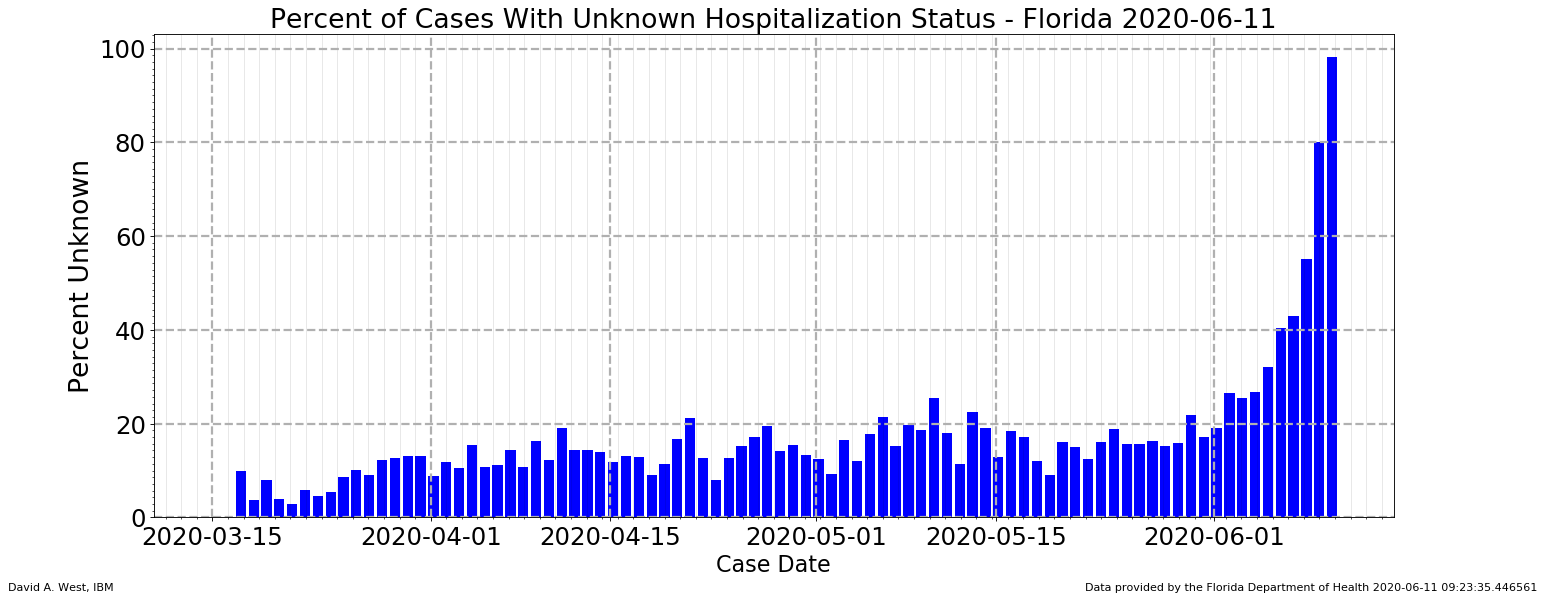

In [122]:
title = "Percent of Cases With Unknown Hospitalization Status - Florida " + nowdate
fig=plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')#.legend( prop={'size': 18})
plt.bar( 'Case1', 'pctunk',data=hosp, color='blue',linewidth=2)
matplotlib.ticker.AutoMinorLocator(n=2)
plt.minorticks_on()
plt.grid( b=True,which='minor', axis='x', color='black', linestyle='-',alpha=0.1)
plt.title(title, fontsize=24)
plt.xlabel('Case Date', fontsize=20)
plt.ylabel('Percent Unknown', fontsize=24)
plt.rcParams['xtick.labelsize'] =22
plt.figtext(0.99, 0.01, 'Data provided by the Florida Department of Health ' + now, horizontalalignment='right')
plt.figtext(0.10, 0.01, 'David A. West, IBM', horizontalalignment='right')
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.grid(which='major', axis='both', linestyle='--',linewidth='2')


## What if all of the UNKNOWNS were actually YES?
## The next chart shows the hospitalization rate if all cases that are currently coded as UNKNOWN were actually YES

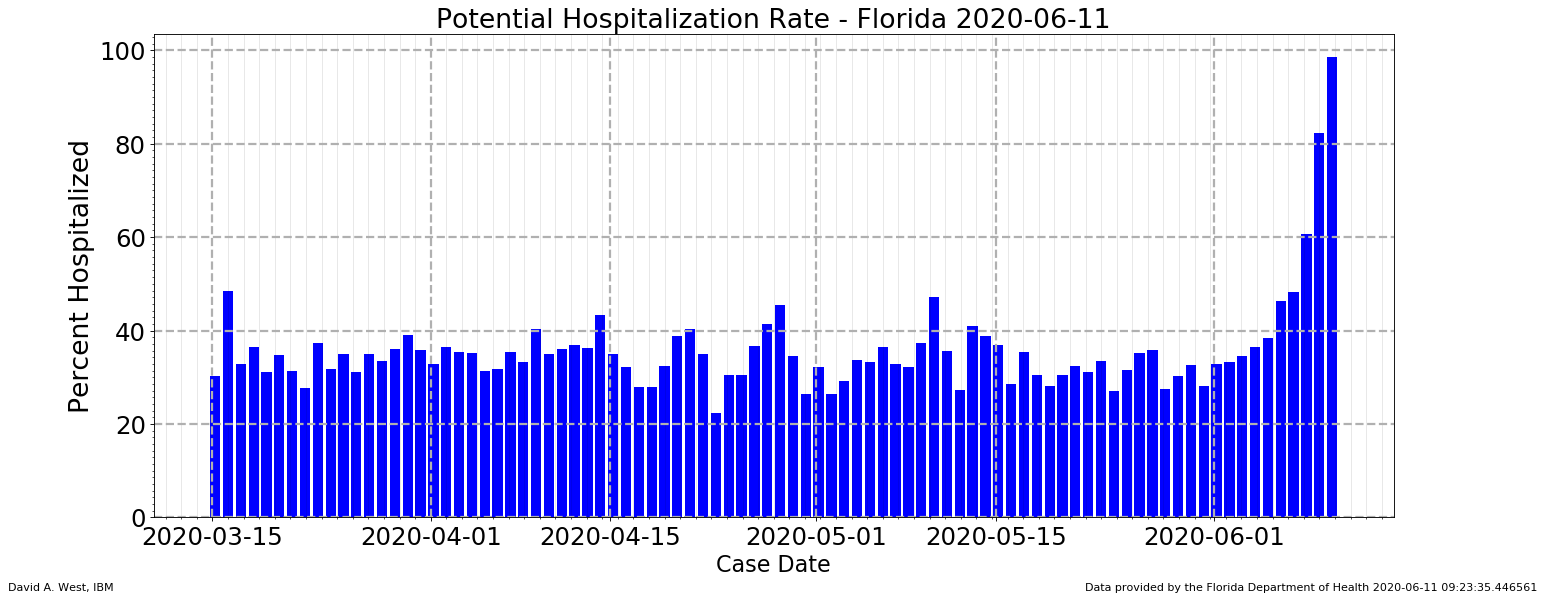

In [123]:

title = "Potential Hospitalization Rate - Florida " + nowdate
fig=plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')#.legend( prop={'size': 18})
plt.bar( 'Case1', 'possible',data=hosp, color='blue',linewidth=2)
matplotlib.ticker.AutoMinorLocator(n=2)
plt.minorticks_on()
plt.grid( b=True,which='minor', axis='x', color='black', linestyle='-',alpha=0.1)
plt.title(title, fontsize=24)
plt.xlabel('Case Date', fontsize=20)
plt.ylabel('Percent Hospitalized', fontsize=24)
plt.rcParams['xtick.labelsize'] =22
plt.figtext(0.99, 0.01, 'Data provided by the Florida Department of Health ' + now, horizontalalignment='right')
plt.figtext(0.10, 0.01, 'David A. West, IBM', horizontalalignment='right')
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.grid(which='major', axis='both', linestyle='--',linewidth='2')


In [58]:
leon = ds5[ds5['County']=='Leon'].sort_values([ 'Case1'])
leon2 = leon[leon['EventDate']>='2020/05/12'] #28 days
leonsort = leon2.sort_values(['Case1'])
leondead = leon[leon['Died']=="Yes"]
leonhosp = leon[leon['Hospitalized']!="NO"]
leonhosp.sort_values(['Age']).reset_index()
leonactive = leon2[leon2['Died']!="Yes"].reset_index()
leonactive[leonactive['Hospitalized']!="NO"].tail(50)

,index,County,Age,Age_group,Gender,Jurisdiction,Travel_related,Origin,EDvisit,Hospitalized,Died,Case_,Contact,Case1,EventDate,ChartDate,ObjectId
36,7754,Leon,44.0,35-44 years,Female,FL resident,Yes,TN,YES,YES,NaN,Yes,YES,2020-05-24 05:00:00+00:00,2020-05-12 00:00:00+00:00,2020-05-24 05:00:00+00:00,7755
90,11939,Leon,29.0,25-34 years,Male,FL resident,No,NaN,YES,YES,NaN,Yes,NO,2020-05-31 05:00:00+00:00,2020-05-18 00:00:00+00:00,2020-05-31 05:00:00+00:00,11940
91,6216,Leon,60.0,55-64 years,Male,Non-FL resident,Unknown,NaN,UNKNOWN,UNKNOWN,NaN,Yes,NaN,2020-06-01 05:00:00+00:00,2020-06-01 00:00:00+00:00,2020-06-01 05:00:00+00:00,6217
106,14569,Leon,49.0,45-54 years,Male,FL resident,No,NaN,NO,YES,NaN,Yes,NO,2020-06-02 05:00:00+00:00,2020-05-25 00:00:00+00:00,2020-06-02 05:00:00+00:00,14570
121,16128,Leon,70.0,65-74 years,Female,FL resident,No,NaN,YES,YES,NaN,Yes,UNKNOWN,2020-06-06 05:00:00+00:00,2020-06-04 00:00:00+00:00,2020-06-06 05:00:00+00:00,16129


In [44]:
leondead

,County,Age,Age_group,Gender,Jurisdiction,Travel_related,Origin,EDvisit,Hospitalized,Died,Case_,Contact,Case1,EventDate,ChartDate,ObjectId
21886,Leon,48.0,45-54 years,Female,Non-FL resident,Yes,GA,YES,YES,Yes,Yes,YES,2020-03-18 05:00:00+00:00,2020-03-10 00:00:00+00:00,2020-03-18 05:00:00+00:00,21887
34860,Leon,49.0,45-54 years,Male,FL resident,No,NaN,YES,YES,Yes,Yes,YES,2020-04-08 05:00:00+00:00,2020-04-04 00:00:00+00:00,2020-04-08 05:00:00+00:00,34861
37039,Leon,62.0,55-64 years,Male,FL resident,No,NaN,YES,YES,Yes,Yes,YES,2020-04-09 05:00:00+00:00,2020-04-06 00:00:00+00:00,2020-04-09 05:00:00+00:00,37040
40249,Leon,71.0,65-74 years,Male,FL resident,No,NaN,YES,YES,Yes,Yes,YES,2020-04-10 05:00:00+00:00,2020-04-08 00:00:00+00:00,2020-04-10 05:00:00+00:00,40250
42332,Leon,31.0,25-34 years,Male,Non-FL resident,Yes,GA,YES,YES,Yes,Yes,YES,2020-04-12 05:00:00+00:00,2020-04-12 00:00:00+00:00,2020-04-12 05:00:00+00:00,42333
41724,Leon,62.0,55-64 years,Female,FL resident,No,NaN,YES,YES,Yes,Yes,YES,2020-04-13 05:00:00+00:00,2020-04-08 00:00:00+00:00,2020-04-13 05:00:00+00:00,41725
43268,Leon,61.0,55-64 years,Male,FL resident,No,NaN,YES,YES,Yes,Yes,Yes,2020-04-16 05:00:00+00:00,2020-04-13 00:00:00+00:00,2020-04-16 05:00:00+00:00,43269
47262,Leon,27.0,25-34 years,Male,Non-FL resident,Yes,GA,YES,YES,Yes,Yes,YES,2020-04-19 05:00:00+00:00,2020-04-19 00:00:00+00:00,2020-04-19 05:00:00+00:00,47263
49214,Leon,81.0,75-84 years,Female,FL resident,No,NaN,NO,YES,Yes,Yes,NO,2020-04-19 05:00:00+00:00,2020-04-12 00:00:00+00:00,2020-04-19 05:00:00+00:00,49215
49930,Leon,63.0,55-64 years,Male,Non-FL resident,Yes,GA,NO,NO,Yes,Yes,NO,2020-04-21 05:00:00+00:00,2020-04-21 00:00:00+00:00,2020-04-21 05:00:00+00:00,49931


In [45]:
dead = leondead.drop(['County','Age_group','EventDate','ChartDate','Case_','Contact'], axis=1, inplace=False)
dead

,Age,Gender,Jurisdiction,Travel_related,Origin,EDvisit,Hospitalized,Died,Case1,ObjectId
21886,48.0,Female,Non-FL resident,Yes,GA,YES,YES,Yes,2020-03-18 05:00:00+00:00,21887
34860,49.0,Male,FL resident,No,NaN,YES,YES,Yes,2020-04-08 05:00:00+00:00,34861
37039,62.0,Male,FL resident,No,NaN,YES,YES,Yes,2020-04-09 05:00:00+00:00,37040
40249,71.0,Male,FL resident,No,NaN,YES,YES,Yes,2020-04-10 05:00:00+00:00,40250
42332,31.0,Male,Non-FL resident,Yes,GA,YES,YES,Yes,2020-04-12 05:00:00+00:00,42333
41724,62.0,Female,FL resident,No,NaN,YES,YES,Yes,2020-04-13 05:00:00+00:00,41725
43268,61.0,Male,FL resident,No,NaN,YES,YES,Yes,2020-04-16 05:00:00+00:00,43269
47262,27.0,Male,Non-FL resident,Yes,GA,YES,YES,Yes,2020-04-19 05:00:00+00:00,47263
49214,81.0,Female,FL resident,No,NaN,NO,YES,Yes,2020-04-19 05:00:00+00:00,49215
49930,63.0,Male,Non-FL resident,Yes,GA,NO,NO,Yes,2020-04-21 05:00:00+00:00,49931


In [115]:
agegps = ds5.groupby(['Age']).count().reset_index()
ds5['Died'].unique()

array([nan, 'Yes'], dtype=object)

In [116]:
agegps['CFR'] = 100 * agegps['Died'] / agegps['Case1']
agegps

,Age,County,Age_group,Gender,Jurisdiction,Travel_related,Origin,EDvisit,Hospitalized,Died,Case_,Contact,Case1,EventDate,ChartDate,ObjectId,CFR
0,0.0,202,202,202,202,202,4,196,201,0,202,177,202,202,202,202,0.000000
1,1.0,134,134,134,134,134,1,128,134,0,134,121,134,134,134,134,0.000000
2,2.0,128,128,128,128,128,0,125,127,0,128,120,128,128,128,128,0.000000
3,3.0,139,139,139,139,139,2,134,139,0,139,123,139,139,139,139,0.000000
4,4.0,117,117,117,117,117,1,111,116,0,117,109,117,117,117,117,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,103.0,8,8,8,8,8,0,8,8,4,8,8,8,8,8,8,50.000000
104,104.0,3,3,3,3,3,0,3,3,1,3,3,3,3,3,3,33.333333
105,105.0,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,0.000000
106,107.0,2,2,2,2,2,0,1,1,0,2,1,2,2,2,2,0.000000


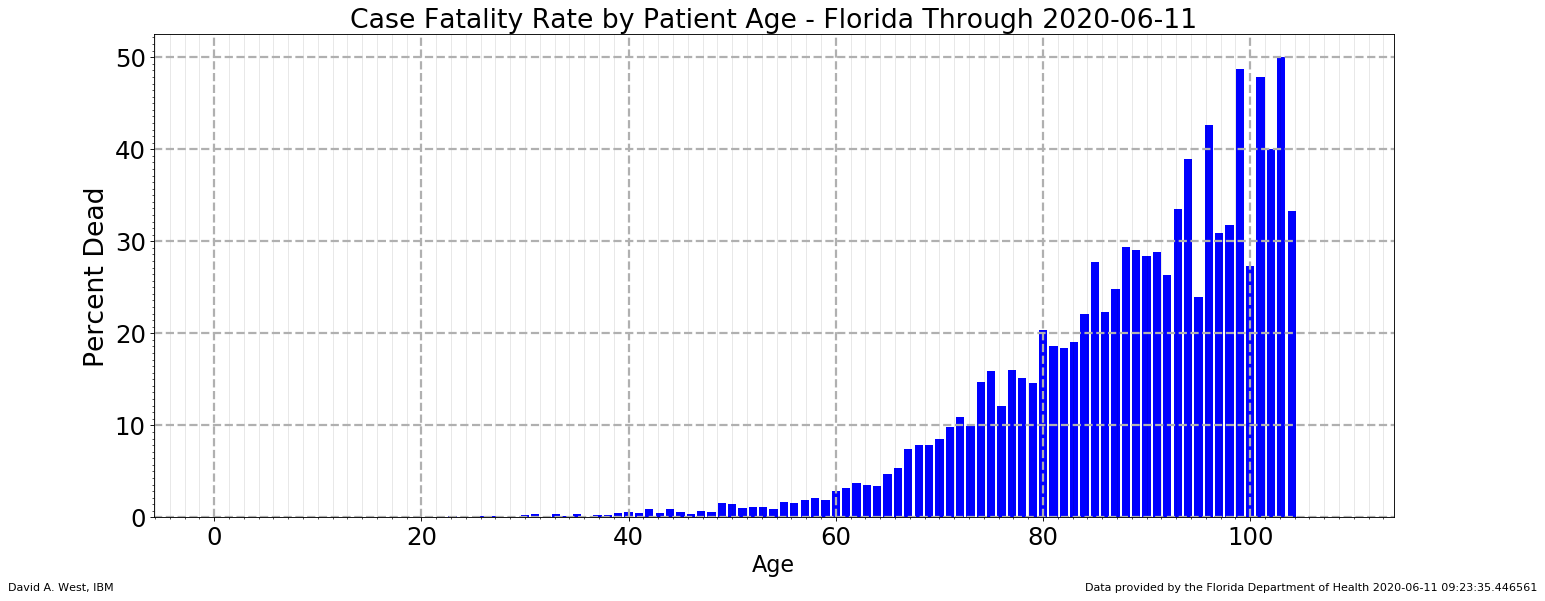

In [117]:
title = "Case Fatality Rate by Patient Age - Florida Through " + nowdate
fig=plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')#.legend( prop={'size': 18})
plt.bar( 'Age', 'CFR',data=agegps, color='blue',linewidth=2)
matplotlib.ticker.AutoMinorLocator(n=2)
plt.minorticks_on()
plt.grid( b=True,which='minor', axis='x', color='black', linestyle='-',alpha=0.1)
plt.title(title, fontsize=24)
plt.xlabel('Age', fontsize=20)
plt.ylabel('Percent Dead', fontsize=24)
plt.rcParams['xtick.labelsize'] =22
plt.figtext(0.99, 0.01, 'Data provided by the Florida Department of Health ' + now, horizontalalignment='right')
plt.figtext(0.10, 0.01, 'David A. West, IBM', horizontalalignment='right')
plt.tick_params(axis='both', which='minor', labelsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.grid(which='major', axis='both', linestyle='--',linewidth='2')
#plt.bar( 'Age', 'Died',data=agegps, color='red',linewidth=2)
#plt.bar( 'Age', 'Hospitalized',data=agegps,  color='green',linewidth=2)

<BarContainer object of 108 artists>

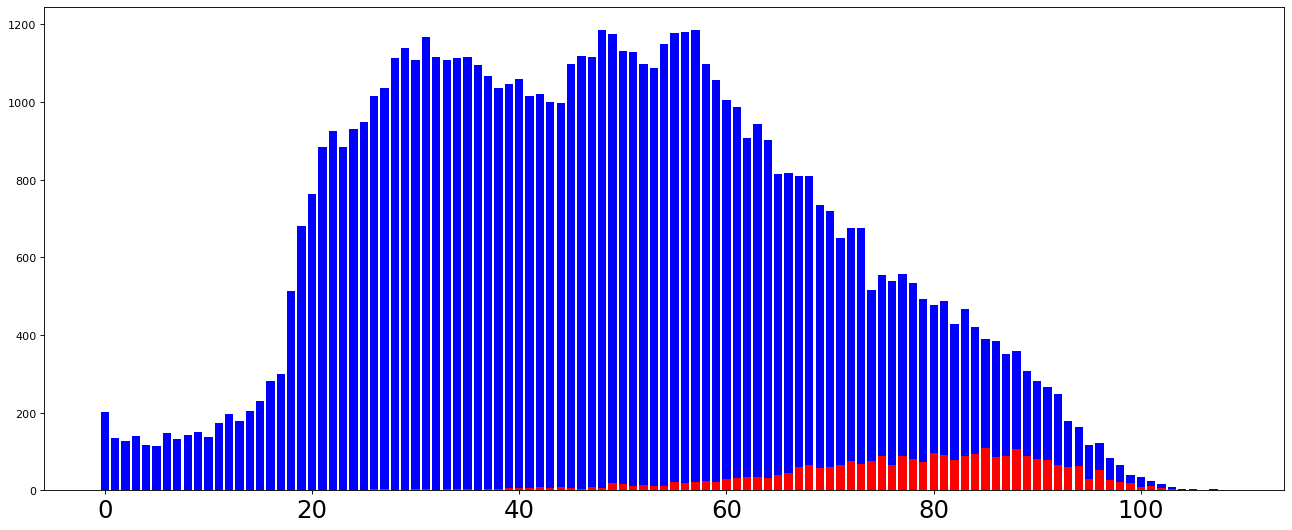

In [118]:
fig=plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')#.legend( prop={'size': 18})
plt.bar( 'Age', 'Case1',data=agegps, color='blue',linewidth=2)
plt.bar( 'Age', 'Died',data=agegps, color='red',linewidth=2)
#plt.bar( 'Age', 'Hospitalized',data=agegps,  color='green',linewidth=2)